In [1]:
#Siinses töös on mul andmestiku muretsemine ja analüüsimine kahes erifailis, kuna andmestiku kättesaamiseks on mul vaja JupyterLab'i siseselt käske kasutada.
#Juhendi järgi võtan siit väikse andmestiku, millega tegeleda RStudio's edasi.

#Kasutasin siinset juhendit: https://digilab.rara.ee/tooriistad/ligipaas-dea-tekstidele/

suppressPackageStartupMessages(library(digar.txts,lib.loc="/gpfs/space/projects/digar_txt/R/4.3/"))
suppressPackageStartupMessages(library(tidyverse,lib.loc="/gpfs/space/projects/digar_txt/R/4.3/"))
suppressPackageStartupMessages(library(tidytext,lib.loc="/gpfs/space/projects/digar_txt/R/4.3/"))
library(dplyr)
library(ggplot2)
library(stringr)
library(tidyverse)

In [2]:
#Andmestiku sisu ülevaade
all_issues <- get_digar_overview()

#Oma valim/subset andmestikust, filtreerides ainult ajalehed aastavahemikus 1920-1939.
subset <- all_issues %>%
    filter(DocumentType == "NEWSPAPER") %>%
    filter(year >= 1920 & year <= 1939)
#   filter(LogicalSectionType == "ADVERTISEMENT")  

[1] "Issue metadata read"


In [3]:
#Tutvun andmetega
is(all_issues)
dim(subset)
#summary(all_issues)
names(subset)
#glimpse(subset)
unique(all_issues$DocumentType)

[1] "data.table" "data.frame" "list"       "oldClass"   "vector"

[1] 129269     60

[1] "DocumentID"            "keyid"                 "attrs"                
 [4] "DocumentDate"          "DocumentTitle"         "DocumentType"         
 [7] "series"                "DocumentNumber"        "DocumentVolume"       
[10] "pages"                 "sections"              "pages_sections"       
[13] "dateraw"               "date"                  "day"                  
[16] "month"                 "year"                  "firstyear"            
[19] "lastyear"              "title"                 "issues"               
[22] "zippath_pages"         "zippath_sections"      "basename_pages"       
[25] "basename_sections"     "access"                "user_access"          
[28] "latest_available"      "rights_en"             "rights_et"            
[31] "rights_ru"             "embargo_en"            "embargo_et"           
[34] "embargo_ru"            "language"              "country"              
[37] "notes_en"              "notes_et"              "notes_ru"             
[40] "permalink"             "place"                 "publisher"            
[43] "section"               "type"                  "ester_id"             
[46] "total_open"            "offlimits"             "access_now"           
[49] "temp"                  "n_articles"            "n_pages"              
[52] "n_articles_lemmas"     "n_pages_lemmas"        "n_articles_metadata"  
[55] "n_pages_metadata"      "pages_exist"           "sections_exist"       
[58] "decade"                "zippath_pages_meta"    "zippath_sections_meta"

[1] "PERIODICAL" "NEWSPAPER"

In [4]:
#Võtan oma valimi metaandmed
subset_meta <- get_subset_meta(subset)
dim(subset_meta)
names(subset_meta)

Warning message in data.table::fread(cmd = x, fill = T):
“File '/tmp/Rtmp3kCRBA/file27e696b81047e' has size 0. Returning a NULL data.table.”
Warning message in data.table::fread(cmd = x, fill = T):
“File '/tmp/Rtmp3kCRBA/file27e69221ac81d' has size 0. Returning a NULL data.table.”
Warning message in data.table::fread(cmd = x, fill = T):
“File '/tmp/Rtmp3kCRBA/file27e6974892861' has size 0. Returning a NULL data.table.”


[1] 2484675      17

[1] ".id"                                "docid"                             
 [3] "LogicalSectionFirstPageID"          "LogicalSectionID"                  
 [5] "attrs"                              "LogicalSectionTitle"               
 [7] "LogicalSectionType"                 "LogicalSectionViewURL"             
 [9] "LogicalSectionTextWordCount"        "LogicalSectionPrevLogicalSectionID"
[11] "LogicalSectionNextLogicalSectionID" "PageOCRAccuracy"                   
[13] "MeanOCRAccuracyVol"                 "date"                              
[15] "dateraw"                            "year"                              
[17] "decade"

In [5]:
#Märksõnaotsing oma valimist, märksõnadeks "tubak", "pabeross", "sigar" ning "suits", kus andmed on lemmatiseeritud.
do_subset_search(searchterm = "tubak|suits|sigar|pabeross", searchfile = "tubakaregex.txt", subset, searchtype = "lemmas")

In [6]:
#Märksõnaotsingu tulemuste .txt faili teisendamine ning metaandmetega ühildumine.
tekstid <- fread("tubakaregex.txt",header=F)[,.(id=V1,txt=V2)]
tekstid_metaga <- tekstid %>% left_join(subset_meta, by = c("id" = "LogicalSectionID"))

#Digilab tööriistadest leitud võimalus lehekülgede kaupa allikate leidmise jaoks, tõenäoliselt ei kasuta töös
#segmenteerimata_tekstid <- tekstid <- fread("segmenteerimata_tubakaregex.txt",header=F)[,.(id=V1,txt=V2)]
#segmenteerimata_tekstid_metaga <- tekstid %>% left_join(subset_meta, by = c("id" = "LogicalSectionID"))

Warning message in fread("tubakaregex.txt", header = F):
“Found and resolved improper quoting in first 100 rows. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”


In [7]:
#Kontroll, kas andmed ühildunud.
names(tekstid_metaga)
names(tekstid)
dim(tekstid_metaga)

[1] "id"                                 "txt"                               
 [3] ".id"                                "docid"                             
 [5] "LogicalSectionFirstPageID"          "attrs"                             
 [7] "LogicalSectionTitle"                "LogicalSectionType"                
 [9] "LogicalSectionViewURL"              "LogicalSectionTextWordCount"       
[11] "LogicalSectionPrevLogicalSectionID" "LogicalSectionNextLogicalSectionID"
[13] "PageOCRAccuracy"                    "MeanOCRAccuracyVol"                
[15] "date"                               "dateraw"                           
[17] "year"                               "decade"

[1] "id"  "txt"

[1] 85614    18

In [8]:
#Tekstid_metaga "suits" filtri loomine, et saada lahti suitsukalast, suitsuvorstist jms. Sõna "suits" peab esinema koos teiste sõnadega.
#Filtreerime tekstid_metaga, kus on tubak|sigar|pabeross|suits, kuid suitsul on tingimus, et suits peab esinema koos teiste sõnadega.

tekstid_metaga_filtered <- tekstid_metaga %>%
    filter(
    # Tingimus 1: Sisaldab 'sigar', 'pabeross' või 'tubak'
        grepl("sigar|pabeross|tubak", txt, ignore.case = TRUE) |
    # VÕI Tingimus 2: Sisaldab 'suits' JA ('sigar', 'pabeross' või 'tubak')
        (grepl("suits", txt, ignore.case = TRUE) & grepl("sigar|pabeross|tubak", txt, ignore.case = TRUE))
      )

In [9]:
dim(tekstid_metaga_filtered)
dim(tekstid_metaga)

[1] 46172    18

[1] 85614    18

In [10]:
#andmestik
write.csv(tekstid_metaga_filtered, file = "tekstid_metaga.csv", row.names = FALSE)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


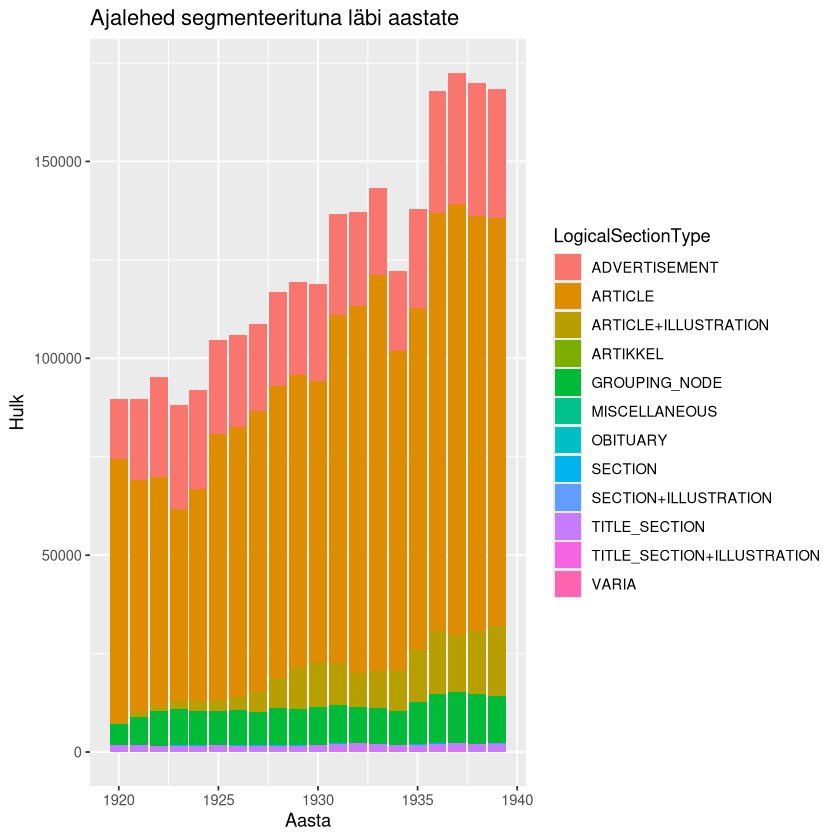

In [11]:
#kui palju leidub reklaame, artikleid jms - lõputöö graafik
subset_meta %>%
  group_by(year, LogicalSectionType) %>%  #Grupeeri aastate ja tüüpidena.
  summarise(count = n()) %>%  #Koguhulga saamine
  ggplot(aes(x = year, y = count, fill = LogicalSectionType)) +  #x telg on aasta, y telg on hulk
  geom_col() +  #barplot
  labs(title = "Ajalehed segmenteerituna läbi aastate", 
       x = "Aasta", 
       y = "Hulk")  #teljepealkirjad

In [12]:
#test lemmata analüüsiks
#do_subset_search(searchterm = "tubak|suits|sigar|pabeross", searchfile = "tubakaregexlemmata.txt", subset)
#tekstid_lemmata <- fread("tubakaregexlemmata.txt",header=F)[,.(id=V1,txt=V2)]
#tekstid_metaga_lemmata <- tekstid %>% left_join(subset_meta, by = c("id" = "LogicalSectionID"))
#write.csv(tekstid_metaga_lemmata, file = "tekstid_metaga.csv", row.names = FALSE)

In [13]:
#Vaatan, kui palju on uuseesti reklaame alaandmestikus.
sum(str_detect(tekstid_metaga_filtered$id, "uuseesti"))


[1] 2471

In [14]:
#Piiritlen tekstid_metaga, et konkordantsid ühildada
paevalehe_reklaamid <- tekstid_metaga_filtered %>%
  filter(LogicalSectionType == "ADVERTISEMENT",
         str_detect(docid, "postimees|sakala|kaja|paevaleht|uuseesti"))
dim(paevalehe_reklaamid)

#Vana tubakaregex.txt tulemusega oli mul 23 654 suurune "paevalehe_reklaamid" andmestik, nüüd on mul 17 061 tulemust. Tulemus klapib, kuna bakat66.Rmd tehtud "suits2" data frame suurus on 2130 ning "suits" data frame suurus 8687 ja need üksteisest lahutada annab sama tulemuse mis 23 654 - 17 061.

[1] 17061    18

In [15]:
#Vaatan, kui palju on uueesti reklaame tubakakorpuses.
sum(str_detect(paevalehe_reklaamid$id, "uuseesti"))

[1] 554

In [16]:
#Järgmisena, et teha korraliku analüüsi sõnadele, hangin konkordantsid, kuna suur osa reklaame pole eraldi kategoriseeritud, vaid nt ühe reklaami alla võib kuuluta kuni 10 reklaami.

concs100 <- get_concordances(searchterm="(?i)tubak|suits|sigar|pabeross",texts=paevalehe_reklaamid,before=100,after=100,txt="txt",id="id")
#(?i)\\btubak[[:alpha:]]*|\\bsigar[[:alpha:]]*|\\bpabeross[[:alpha:]]* tubak|suits|sigar|pabeross (?i).*tubak.*|.*suits.*|.*sigar.*|.*pabeross.*|.*sigaret.*
dim(concs100)

write.csv(concs100, file = "concs100.csv", row.names = FALSE)

[1] 34855    21

In [17]:
dim(concs100)
names(paevalehe_reklaamid)
names(concs100)
#Kuna on näha, et konkordantsid leiavad "ühes" reklaamis mitu tulemust nende märksõnadega, ühildan ma korduvad tulemused ühe id alla.
#Tahan iga dokumendi kohta vaid ühe tulemuse (nt ainult esimene leitud kontekst)

combined <- paevalehe_reklaamid %>%
    left_join(concs100 %>% select(id, begin, end, context), by = "id")

dim(combined)
names(combined)

paevalehe_reklaamid_concs <- combined %>%
    group_by(id) %>%
    slice(1) %>%
    ungroup() #%>%

dim(paevalehe_reklaamid_concs)
names(paevalehe_reklaamid_concs)

[1] 34855    21

[1] "id"                                 "txt"                               
 [3] ".id"                                "docid"                             
 [5] "LogicalSectionFirstPageID"          "attrs"                             
 [7] "LogicalSectionTitle"                "LogicalSectionType"                
 [9] "LogicalSectionViewURL"              "LogicalSectionTextWordCount"       
[11] "LogicalSectionPrevLogicalSectionID" "LogicalSectionNextLogicalSectionID"
[13] "PageOCRAccuracy"                    "MeanOCRAccuracyVol"                
[15] "date"                               "dateraw"                           
[17] "year"                               "decade"

[1] "id"                                 ".id"                               
 [3] "docid"                              "LogicalSectionFirstPageID"         
 [5] "attrs"                              "LogicalSectionTitle"               
 [7] "LogicalSectionType"                 "LogicalSectionViewURL"             
 [9] "LogicalSectionTextWordCount"        "LogicalSectionPrevLogicalSectionID"
[11] "LogicalSectionNextLogicalSectionID" "PageOCRAccuracy"                   
[13] "MeanOCRAccuracyVol"                 "date"                              
[15] "dateraw"                            "year"                              
[17] "decade"                             "nr"                                
[19] "begin"                              "end"                               
[21] "context"

[1] 34855    21

[1] "id"                                 "txt"                               
 [3] ".id"                                "docid"                             
 [5] "LogicalSectionFirstPageID"          "attrs"                             
 [7] "LogicalSectionTitle"                "LogicalSectionType"                
 [9] "LogicalSectionViewURL"              "LogicalSectionTextWordCount"       
[11] "LogicalSectionPrevLogicalSectionID" "LogicalSectionNextLogicalSectionID"
[13] "PageOCRAccuracy"                    "MeanOCRAccuracyVol"                
[15] "date"                               "dateraw"                           
[17] "year"                               "decade"                            
[19] "begin"                              "end"                               
[21] "context"

[1] 17061    21

[1] "id"                                 "txt"                               
 [3] ".id"                                "docid"                             
 [5] "LogicalSectionFirstPageID"          "attrs"                             
 [7] "LogicalSectionTitle"                "LogicalSectionType"                
 [9] "LogicalSectionViewURL"              "LogicalSectionTextWordCount"       
[11] "LogicalSectionPrevLogicalSectionID" "LogicalSectionNextLogicalSectionID"
[13] "PageOCRAccuracy"                    "MeanOCRAccuracyVol"                
[15] "date"                               "dateraw"                           
[17] "year"                               "decade"                            
[19] "begin"                              "end"                               
[21] "context"

In [18]:
write.csv(paevalehe_reklaamid_concs, file = "paevalehe_reklaamid_concs.csv", row.names = FALSE)